In [2]:
#! -*- coding: utf-8 -*-

## 3. PyCBCチュートリアル：波形の生成とマッチトフィルタ

コンパクトバイナリマージャーによる天体物理源の発見、重力波データの研究、それらのパラメータの研究に使用される[PyCBC](http://github.com/ligo-cbc/pycbc)ライブラリを使用します。 これらは、LIGOとVirgoの協力がLIGO / Virgoデータの重力波を見つけるために使用するのと同じツールです

このチュートリアルでは、LIGOデータで特定の信号を見つける方法を説明します。 我々は、ガウス雑音と既知の信号モデルの場合に最適な、重力波マージャーとマッチトフィルタリングの波形を生成する方法を提示する。 実際には私たちのノイズは完全にガウシアンではなく、実際にはマッチドフィルタの使用に加えてノイズから信号を分離するためにさまざまなテクニックを使用しています。

他の[例](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) とモジュールレベルのドキュメンテーションは[ここ](http://pycbc.org/pycbc/latest/html/py-modindex.html)にあります。

### 最初の波形を生成してください！

ここでは、利用可能な波形近似値の1つを使用して重力波形を生成します。これらは、[`get_td_waveform`](http://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_td_waveform)を使用して時系列として生成できます。このインターフェース[ここ](http://pycbc.org/pycbc/latest/html/waveform.html)を使用したいくつかの追加の例があります。重要なパラメータは、バイナリの質量（太陽質量を単位とする）、サンプル間の時間（秒）、開始重力波周波数（Hz）、生成する近似値の名前です。異なる物理的効果を含む様々な近似値が利用可能である。さまざまなモデルの完全なレビューは、このチュートリアルの範囲外です。

この例では、 'SEOBNRv4_opt'モデルを使用することにしました。さまざまな方法論を持ち、異なる物理的効果を含む他の多くの方法もあります。これは、[この論文](https://arxiv.org/pdf/1611.03703.pdf)のモデルの実装です。インスパイラルおよびマージするブラックホールの重力波形をモデル化し、各ブラックホールが軌道と同じ方向に回転する自由度（スピンが整列した場合）も含みます。

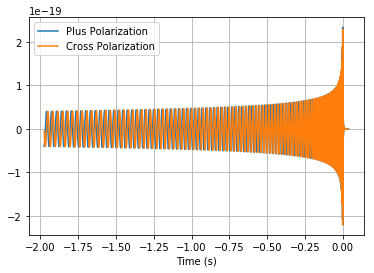

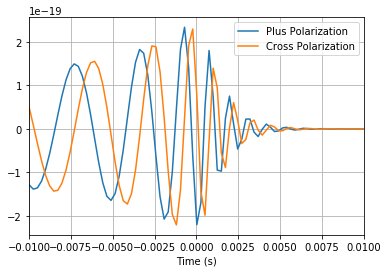

In [3]:
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab

# The output of this function are the "plus" and "cross" polarizations of the gravitational-wave signal 
# as viewed from the line of sight at a given source inclination (assumed face-on if not provided)
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30)

pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time#
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.xlim(-.01, .01)
pylab.legend()
pylab.grid()
pylab.show()

この場合、2つの偏光は信号の位相だけが異なることがわかります。 これは、バイナリの軌道面が歳差運動をしないシステムに適用されます。 ズームインプロットでは、マージャ自体とそれに続くリングダウンを見ることができます。

### バイナリの質量で波形はどのように変化しますか？

以下では、バイナリマージの質量が小さくなると波長がどのように増加するかを見ることができます。

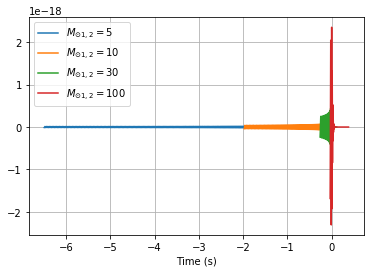

In [4]:
# Component mass of each binary component. We'll simplify here and assume that each 
# component of the binary has the same mass. Again, units are in solar masses.
for m in [5, 10, 30, 100]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m,
                         mass2=m,
                         delta_t=1.0/4096,
                         f_lower=30)
    
    pylab.plot(hp.sample_times, hp, label='$M_{\odot 1,2}=%s$' % m)
pylab.legend()
pylab.grid()
pylab.xlabel('Time (s)')
pylab.show()

### マージャーまでの距離を変更する

マージャーまでの距離は、波形を生成するときにも選択できます。 使用される単位はメガパーセクです。 ここでは赤方偏移効果は考慮されていないので、距離と振幅の間には単純な線形関係があります

In [5]:
for d in [100, 500, 1000]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30,
                         distance=d)
    
    pylab.plot(hp.sample_times, hp, label='$Distance=%sMpc$' % d)
pylab.legend()
pylab.grid()
pylab.xlabel('Time (s)')
pylab.show()

### データ内の特定の信号を探す

データ内でどの信号を探しているのか知っていれば、マッチトフィルタリングはガウシアン雑音の中のsiganlを抽出するのに最適な方法として知られています。 信号のパラメータが分からなくても、各パラメータセットをテストすることができます。

#### データの前処理
 
これは、データのダイナミックレンジを減らし、数値的アーチファクトを導入する可能性のある低周波信号を抑制することを目的としています。 高周波成分が重要でない場合は、データをリサンプリングすることもできます。

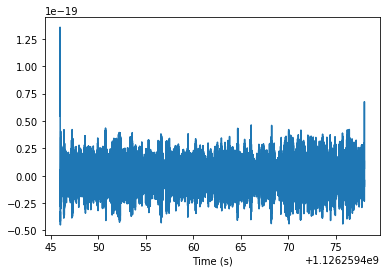

In [6]:
# As an example we use the GW150914 data
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

merger = Merger("GW150914")

# Get the data from the Hanford detector
strain = merger.strain('H1')

# Remove the low frequency content and downsample the data to 2048Hz
strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

#### フィルタラップアラウンド

境界のデータのスパイクに注意してください。 これは、データをフィルタリングするハイパスおよびリサンプリング段階によって発生します。 フィルタが境界に適用されると、フィルタはデータの先頭にラップアラウンドします。 データ自体は不連続性を有する（すなわち、周期的ではない）ので、フィルタ自体は、フィルタの長さまでの時間、リング・オフする。

目に見える過渡現象が見られなくても、因果関係のない時間に作用するフィルタは避けたい。 これを避けるために、データの終わりを十分にトリムして、入力をラップアラウンドしないようにします。 フィルタリングのすべての手順でこの要件を適用します。

In [7]:
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

#### パワースペクトル密度を計算する

最適なマッチドフィルタリングは、潜在的な信号およびデータの周波数成分にノイズ振幅を重み付けすることを必要とする。 このことは、1 / PSDの時系列相当でデータをフィルタリングすることとみなすことができます。 このフィルタをどのくらいデータに適用するかを制御できるように、PSDの時系列相当を特定の長さにウィンドウします。 しかし、これは検出器の線の挙動に関する情報を失うという影響がありますが、信号の周波数範囲が広く、線が狭いため、これは無視できる影響です。

calculate the power spectral density

Optimal matched filtering requires weighting the frequency components of the potential signal and data by the noise amplitude. We can view this as filtering the data with the time series equivelant of 1 / PSD. To ensure that we can control how much applying this filter to the data, we window the time domain equivelant of the PSD to a specific length. This has effect of losing some information about line behavior in the detector, however, since our signal span a large frequency range, and lines are narrow, this is a negligible effect.

In [8]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samles of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner

psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to informat the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, 4 * conditioned.sample_rate,
                                  low_frequency_cutoff=15)

#### あなたのシグナルモデルを作る

概念的には、マッチトフィルタリングでは、潜在的な信号をデータに重ね、積分する（周波数を正しく重み付けした後）。 あなたの 'テンプレート'に合わせてデータに信号がある場合、積分したときに大きな値が得られます。

In [9]:
# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the SNR time series
# for each one

# We'll assume equal masses, which is within the posterior probability
# of GW150914. 
m = 36 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# This function rotates the vector by a fixed amount of time.
# It treats the data as if it were on a ring. Note that
# time stamps are *not* in general affected, but the true
# position in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(template)
pylab.show()

#### ['clang', '-fno-strict-aliasing', '-I/anaconda/envs/py2/include', '-mmacosx-version-min=10.9', '-m64', '-fPIC', '-DNDEBUG', '-g', '-fwrapv', '-O3', '-Wall', '-Wstrict-prototypes'] #######


#### 信号対雑音時系列を計算する

ここでは、テンプレートの信号対雑音時系列を計算します。 出力時系列を切り捨てることで、フィルタの破損/ラップアラウンドの問題に対応します。 テンプレートの長さと1 / PSDの両方を考慮する必要があります。

In [10]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

We found a signal at 1126259462.42s with SNR 19.1130859925


### 提案信号の整列と減算

前のセクションでは、提案されたバイナリブラックホールの合併について、信号対雑音のピークを観測しました。 このSNRピークを使用して、モデルをデータに整列させ、データからモデルを引き出すことができます。

In [11]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

#### 信号とデータの重なりを視覚化する

データを同等の基準で比較し、重要な周波数範囲に集中する。 テンプレートとデータの両方を白色化し、データとテンプレートの両方を30〜300 Hzでバンドパスします。 このようにして、データ内の信号は、テンプレートと同じ方法で変換されます。

In [12]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

#### データから信号を減算する

テンプレートを整列したので、単純にテンプレートを引くことができます。 時間 - 周波数プロットでどのように見えるかを見てみましょう！

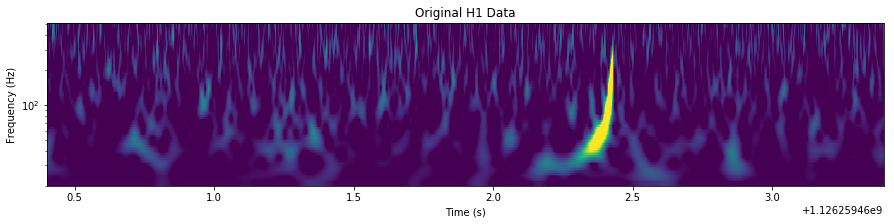

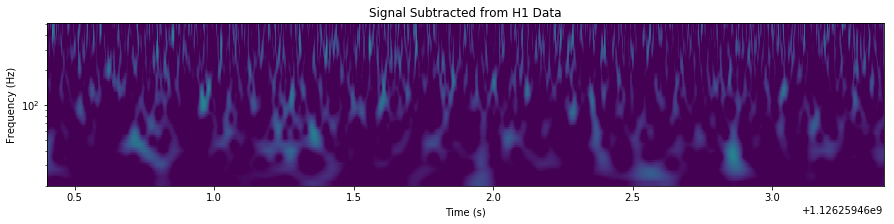

In [13]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()

## チャレンジ！

上記の方法を使用して、SNRを計算できるかどうかを確認してください
次のデータセットの時系列を示します。 各信号のSNRはどれくらいですか？
どのテンプレートがどのデータにマッチしましたか？

役に立つ情報：

* 信号はすべてフレームファイルに100秒から120秒の間に置かれます。
* mass1 = mass1（等質量）、各成分質量は22,36、または50のいずれかとみなすことができます。
* 各ファイルは、gps時間0で開始し、gps時間128で終了します。
* 各ファイルのチャンネル名は "H1：TEST-STRAIN"です。

In [14]:
# Download the challenge set files

import urllib

def get_file(fname):
    url = "https://github.com/ahnitz/odw-storage/raw/master/{}"
    url = url.format(fname)
    urllib.urlretrieve(url, fname)
    print('Getting : {}'.format(url))

files = ['PyCBC_T2_0.gwf', 'PyCBC_T2_2.gwf', 'PyCBC_T2_3.gwf']

for fname in files:
    get_file(fname)

Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_0.gwf
Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_2.gwf
Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_3.gwf
